In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# plt.rcParams["figure.figsize"] = (17, 7)
from tqdm import tqdm

In [ ]:
# !pip install sktime
# !pip install tbats

Что ждем от туториала?

1. Оценить конкретную модель заданного класса. Не только сделать .fit, но и выписать полученное уравнение!
2. Автоматически подобрать модель (встроенный подбор)
3. Построить графики прогнозов, интервальные прогнозы где есть.
4. Сравнить несколько (две-три) модели данного класса с помощью скользящего окна.
5. Творчество, любые дополнения, мемасики :)

Класс выбираем: ETS, ARIMA, BATS + TBATS, PROPHET, случайный лес + создание признаков, GARCH, своё предложить

Цель: когда через год будут люди спрашивать "как в питоне оценить ets/arima?" ответ должен быть "читайте туториалы от нашего курса!"

# TBATS

### Useful links

https://github.com/intive-DataScience/tbats

https://github.com/intive-DataScience/tbats/tree/master/examples

BATS info: https://yintingchou.com/posts/bats-and-tbats-model/

## Model

In [ ]:
from sktime.datasets import load_airline
from sktime.utils.plotting import plot_series
from sklearn.model_selection import train_test_split as tts
from tbats import BATS, TBATS

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/ovyan/data-for-tssp/main/train.csv')
df = df[(df['store'] == 1) & (df['item'] == 1)] # item 1 in store 1
y = df['sales']
y_train = y.iloc[:(len(y)-365)]
y_test = y.iloc[(len(y)-365):] # last year for testing

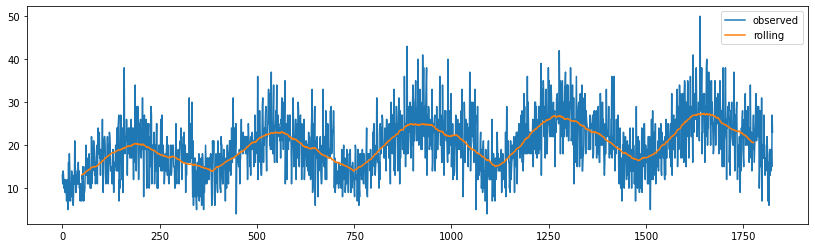

In [ ]:
plt.figure(figsize=(14, 4))
y_roll = y.rolling(100, center=True).mean().dropna()
plt.plot(y.index, y.values, label='observed')
plt.plot(y_roll.index, y_roll, label='rolling')
plt.legend()
plt.show()

We can see that our data has a clear **seasonal** pattern, with a positive **trend**.
The trend and seasonality both seems additive, since the amplitude and variance seems constant.

The legit modeling seems *not to use box-cox* transformation, use *2 seasonal components - 7, 365*
(based on what we've seen and the dataset nature), *trend with no damping*, and maybe catch
the remaining patterns using ARIMA on residuals if needed.

In [ ]:
estimator = TBATS(seasonal_periods=(7, 365), use_box_cox=False) # using box_cox is very slow # )(7, 365.25)
model = estimator.fit(y_train)
y_forecast = model.forecast(steps=365)

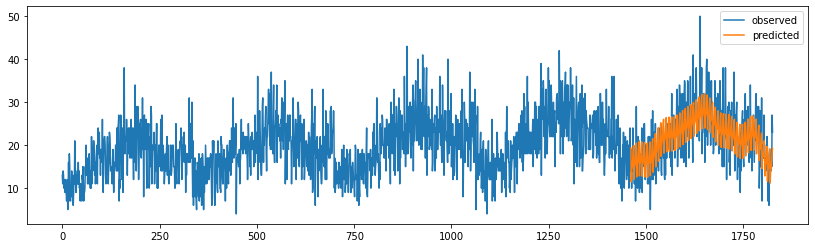

In [ ]:
plt.figure(figsize=(14, 4))
y_forecast_series = pd.Series(y_forecast, index=np.arange(len(y_train), len(y)))
plt.plot(y.index, y.values, label='observed')
plt.plot(y_forecast_series.index, y_forecast_series.values, label='predicted')
plt.legend()
plt.show()

In [ ]:
params = model.params
components = model.params.components

print(model.summary(), '\n')

print('1st seasonal smoothing parameters', params.gamma_1())  # one value for each season
print('2nd seasonal smoothing parameters', params.gamma_2())  # one value for each season

print('Trend and damping', components.use_trend, components.use_damped_trend)
print('Trend', params.beta)
print('Damping', params.phi)

Use Box-Cox: False
Use trend: False
Use damped trend: False
Seasonal periods: [  7. 365.]
Seasonal harmonics [3 6]
ARMA errors (p, q): (0, 0)
Smoothing (Alpha): 0.019709
Seasonal Parameters (Gamma): [ 8.72841724e-09  1.67597743e-08 -1.77469439e-10  1.02000505e-08]
AR coefficients []
MA coefficients []
Seed vector [16.95548585 -2.63423986 -0.19616109  1.19379786 -0.73419187  1.77410447
  0.93199222 -4.68988095 -0.10562745 -1.07813312 -0.03917052 -0.44889777
 -0.07860096 -0.71468207 -0.92257625 -0.69651403  0.23721199  0.54218195
  0.72103407]

AIC 15019.068346 

1st seasonal smoothing parameters [ 8.72841724e-09 -1.77469439e-10]
2nd seasonal smoothing parameters [1.67597743e-08 1.02000505e-08]
Trend and damping False False
Trend None
Damping None


**Model:**

$ y_t = l_{t-1} + b_{t-1} + s_{t-7} + s_{t-365} + d_t$

$ l_t = l_{t-1} + b_{t-1} + 0.0197d_t $

$ b_t = b_{t-1} $

$ d_t = \epsilon_t $

**Seasonal part:**

For $m = 7$ and $m = 365$ separately: $ \omega_i = 2\pi j/m $

For each $m$ the number of harmonics are $k_1 = 3$, $k_2 = 6$

***For m = 7:***
$s_t = \sum_{j=1}^{3} s_{j,t} $

$ s_{j,t} = s_{j,t-1} cos(\omega_i) + s^*_{j,t-1} sin(\omega_i) + 8.7e{-09} d_t $

$ s^*_{j,t} = -s_{j,t-1} sin(\omega_i) + s^*_{j,t-1} cos(\omega_i) + 1.6e{-08} d_t $

***For m = 365:***

$s_t = \sum_{j=1}^{6} s_{j,t} $

$ s_{j,t} = s_{j,t-1} cos(\omega_i) + s^*_{j,t-1} sin(\omega_i) + -1.7e{-10} d_t $

$ s^*_{j,t} = -s_{j,t-1} sin(\omega_i) + s^*_{j,t-1} cos(\omega_i) + 1.02e{-08} d_t $ 

## Comparison

To compare the performance of TBATS models with different seasonal periods and ETS model, we will forecast on the data containing daily sales of an item from a period of 5 years. And we will use the sliding window approach to compare forecasts of these models. 

### Confidence intervals

Firstly, we will construct 95% confidence intervals.

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/ovyan/data-for-tssp/main/train.csv')
df = df[(df['store'] == 1) & (df['item'] == 1)] # item 1 in store 1
y = df['sales']
y_train = y.iloc[:(len(y)-365)]
y_test = y.iloc[(len(y)-365):] # last year for testing

In [ ]:
estimator = TBATS(seasonal_periods=(7, 365), use_box_cox=False) # using box_cox is very slow
model = estimator.fit(y_train)
y_forecast, confidence_info = model.forecast(steps=365, confidence_level=0.95)

In [ ]:
from scipy.ndimage.filters import gaussian_filter1d

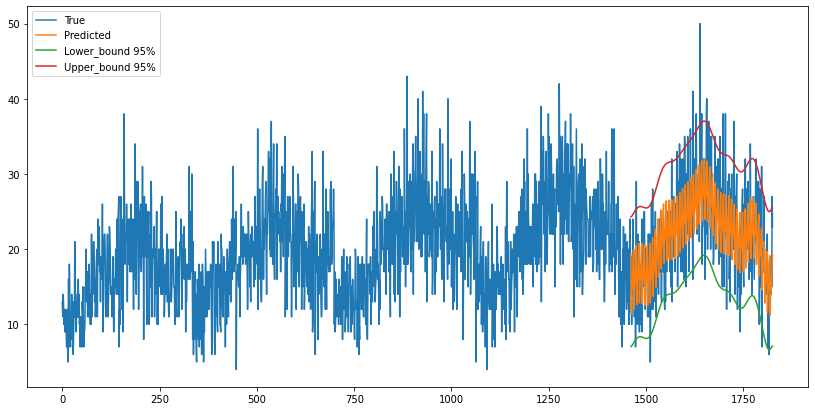

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(np.arange(0, len(y)), y.values, label='True')
plt.plot(np.arange(len(y_to_train), len(y)), y_forecast, label='Predicted')

lb_smoothed = gaussian_filter1d(confidence_info['lower_bound'], sigma=5) 
ub_smoothed = gaussian_filter1d(confidence_info['upper_bound'], sigma=5) 
plt.plot(np.arange(len(y_to_train), len(y)), lb_smoothed, label='Lower_bound 95%')
plt.plot(np.arange(len(y_to_train), len(y)), ub_smoothed, label='Upper_bound 95%')
plt.legend()
plt.show()

We can see that decpite the fact that we have noisy data cofidence interval is not that widem which means that TBATS model is suitable to forecast on this data. 

### Sliding Window

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/ovyan/data-for-tssp/main/train.csv')
df = df[(df['store'] == 1) & (df['item'] == 1)] # item 1 in store 1
y = df['sales']
X = np.arange(len(y))

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.base import ForecastingHorizon

In [ ]:
def moving_window(X, y, window_cnt=3):
    assert len(X) == len(y)
    plt.figure(figsize=(20, 14))
    window_size = len(X) // window_cnt
    for plot_num in range(window_cnt*3):
        cnt = plot_num % window_cnt
        plt.subplot(3, window_cnt, plot_num+1)
        start_, end_ = cnt * window_size, (cnt + 1) * window_size
        X_window, y_window = X[start_ : end_], y[start_ : end_]
        X_train, X_test, y_train, y_test  = tts(X_window, y_window, test_size=0.3, shuffle=False)
        if plot_num < 3:
            model = TBATS(seasonal_periods=(7, 365), use_box_cox=False).fit(y_train) # using box_cox is very slow
            y_forecast = model.forecast(steps=len(y_test))
            plt.title(f"Window {cnt+1} TBATS 7, 365")
        elif plot_num < 6:
            model = TBATS(seasonal_periods=(365,), use_box_cox=False).fit(y_train) # using box_cox is very slow
            y_forecast = model.forecast(steps=len(y_test))
            plt.title(f"Window {cnt+1} TBATS 365")
        elif plot_num < 9:
            model = AutoETS(error='mul', trend=None, seasonal='add', sp=7) # can't set sp=365, not enough data
            model.fit(y_train.astype(np.float64))
            horizon = ForecastingHorizon(X_test, is_relative=False)
            y_forecast = model.predict(horizon)
            plt.title(f"Window {cnt+1} AutoETS MNA")

        plt.plot(X_window, y_window, label='True')
        plt.plot(X_test, y_forecast, label='Prediction')
        plt.legend()
    
    plt.show()


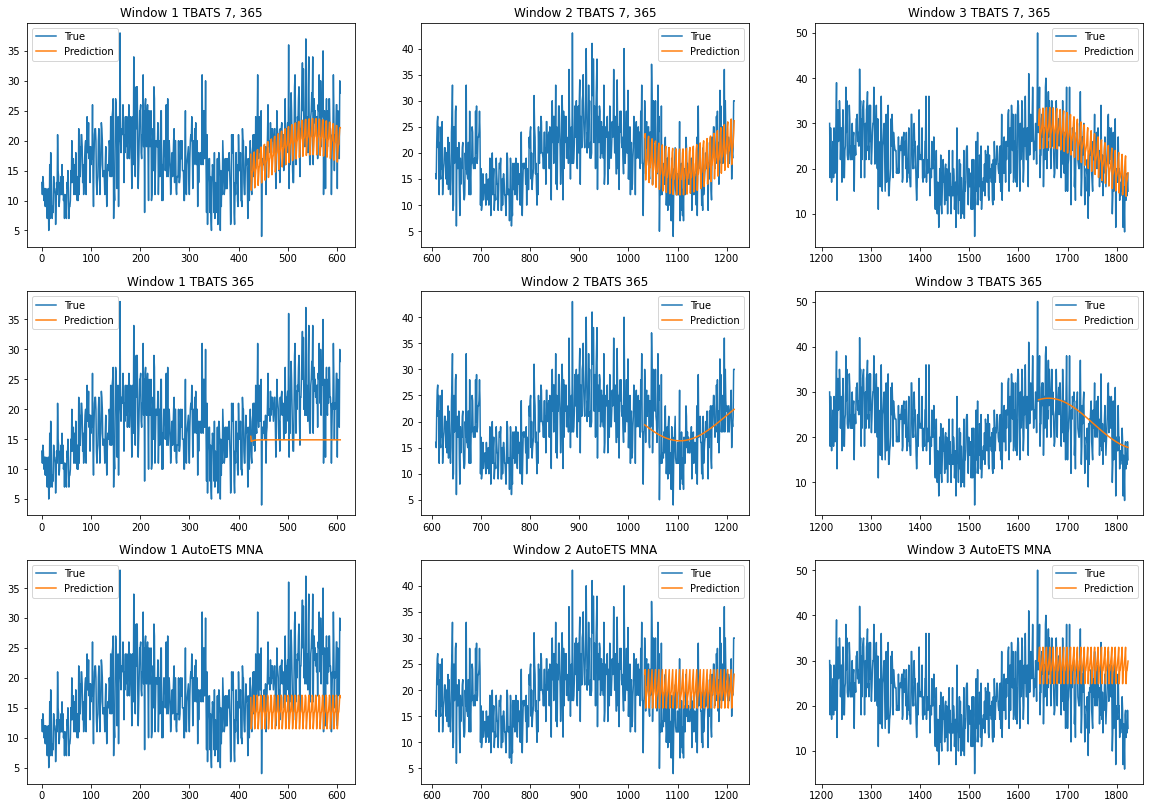

In [ ]:
moving_window(X=X, y=y, window_cnt=3)

It can be seen that the we have a multi-seasonal data, which has yearly and weekly seasonality, therefore TBATS (7, 365) has the best forecast. While others did not perform that well because TBATS (365) covers only yearly seasonal effect and AutoETS on the other hand is focused on weekly seasonality. As you can see, AutoETS wasn't used with an annual seasonality because it requires two full cycles of the season in the data (i.e. 365*2 days), however each window is only around 600. This is also can be considered as a one of the features of TBATS as it can catch seasonality on a small dataset.